# Import libraries

In [28]:
import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt

import scipy
from scipy import optimize
from functools import reduce
from numdifftools import Gradient

from typing import Callable, List, Tuple
import itertools
%matplotlib inline


# Generate noisy data

In [49]:
# Generating random numbers
a = np.random.rand()
b = np.random.rand()

x = np.linspace(0, 1., 101, dtype=np.float64)

In [50]:
a, b

(0.5237462765135157, 0.015975863177065674)

In [51]:
# Generating random data
def fx(x: NDArray[np.float64], alpha: float, beta: float) -> NDArray[np.float64]:
    theta = np.random.randn(101)
    y = alpha * x + beta
    noisy_y = y  + theta
    return y, noisy_y

In [52]:
y, noisy_y = fx(x, a, b)

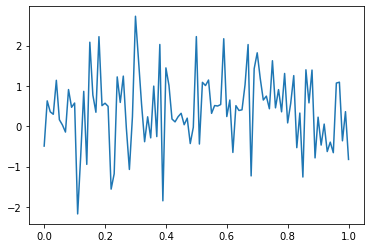

In [53]:
plt.plot(x, noisy_y)

# Define approximating and loss functions 

In [54]:
# linear approximation function
def lin_approx_func(x, a, b):
    return a * x + b

# rational approximation function
def rat_approx_func(x, a, b):        
    return a / (1 + b * x)

In [55]:
# closure of least squares function
def least_squares_linear(y_f, x):
    
    def least_squares_linear_closure(params):
        a, b = params
        return np.sum((lin_approx_func(x, a, b) - y_f) ** 2)
    
    return least_squares_linear_closure

def least_squares_rational(y_f, x):

    def least_squares_rational_closure(params):
        a, b = params
        return np.sum((rat_approx_func(x, a, b) - y_f) ** 2)
    
    return least_squares_rational_closure

In [56]:
least_squares_linear_on_x = least_squares_linear(noisy_y, x)
least_squares_rational_on_x = least_squares_rational(noisy_y, x)

# Different optimization techniques

In [57]:
def gradient_descent(method, a, b, x, y, eps, alpha=1e-3, max_iter=1000):
    path = [(a, b)]

    iter, f_call = 0, 0
    step = 1
    prev_a, prev_b = a, b

    while step >= eps and iter < max_iter:
        iter += 1
        if method == "linear":
            g_a = 2 * np.sum(x * (a * x + b - y))
            g_b = 2 * np.sum(a * x + b - y)
        elif method == "rational":
            grad =  Gradient(least_squares_rational_on_x)([a, b])
            g_a = grad[0]
            g_b = grad[1]
            # g_a = -2 * np.sum((-a  + b * x * y + y) / ((1 + b * x) ** 2))
            # g_b = -2 * np.sum((a * x * (a - y * (b * x + 1))) / ((b * x + 1)**3))

        f_call += 1     

        a -= alpha * g_a
        b -= alpha * g_b
        path.append((a, b))

        #let us use l2 norm of gradient as a condition for stopping
        step = np.sqrt((prev_a - a)**2 + (prev_b - b)**2)
        prev_a, prev_b = a, b
           
    return a, b, iter, f_call, path

In [58]:
def lin_resid(ab, *args):
    a, b = ab
    x, y = args[0], args[1]
    return lin_approx_func(x, a, b) - y

In [59]:
def rat_resid(ab, *args):
    a, b = ab
    x, y = args[0], args[1]
    return rat_approx_func(x, a, b) - y

In [60]:
init_a, init_b = np.random.rand(), np.random.rand()
print('Linear optimization')

a_gd, b_gd, iter, f_call, path = gradient_descent('linear', init_a, init_b , x, noisy_y, 1e-3, .0075)
print(f'Gradient Descent:\t ','Value a: {:.4f} Value b: {:.4f} Number of f-calculations: {:.0f} Number of iterations: {:.0f}'.format(a_gd, b_gd, f_call, iter))

cd = optimize.minimize(least_squares_linear_on_x, [init_a, init_b], method='CG', tol=0.001, options={'disp': True})
print(f'Conjugate Gradient Descent:\t ','Value a: {:.4f} Value b: {:.4f}'.format(cd.x[0], cd.x[1]))

newton = optimize.minimize(least_squares_linear_on_x, [init_a, init_b], method='BFGS', tol=0.001, options={'disp': True})
print(f'Newton’s method:\t ','Value a: {:.4f} Value b: {:.4f}'.format(newton.x[0], newton.x[1]))

lm = optimize.least_squares(lin_resid, [init_a, init_b], args=(x, noisy_y), method='lm', xtol=0.001)
print(f'Levenberg-Marquardt algorithm:\t ','Value a: {:.4f} Value b: {:.4f} Number of f-calculations: {:.0f}'.format(lm.x[0], lm.x[1], lm["nfev"]))

Linear optimization
Gradient Descent:	  Value a: 0.0326 Value b: 0.3972 Number of f-calculations: 90 Number of iterations: 90
Optimization terminated successfully.
         Current function value: 84.425427
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Conjugate Gradient Descent:	  Value a: 0.0324 Value b: 0.3969
Optimization terminated successfully.
         Current function value: 84.425427
         Iterations: 4
         Function evaluations: 18
         Gradient evaluations: 6
Newton’s method:	  Value a: 0.0324 Value b: 0.3969
Levenberg-Marquardt algorithm:	  Value a: 0.0324 Value b: 0.3969 Number of f-calculations: 7


## Visualization of gradient descent

In [61]:
def create_mesh(f):
    x = np.arange(-0.5, 1, 0.01)
    y = np.arange(-0.5, 1, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    mesh_size = range(len(X))

    for i, j in itertools.product(mesh_size, mesh_size):
        x_coor = X[i][j]
        y_coor = Y[i][j]
        Z[i][j] = f(np.array([x_coor, y_coor]))
    return X, Y, Z

In [62]:
def plot_contour(ax, X, Y, Z):
    ax.set(
        title='Path During Gradient discent',
        xlabel='a',
        ylabel='b'
    )
    l_z, r_z  = np.abs(Z).min(), np.abs(Z).max()
    CS = ax.pcolormesh(X, Y, Z,  vmin=l_z, vmax=r_z)
    ax.axis('square')
    return ax, CS

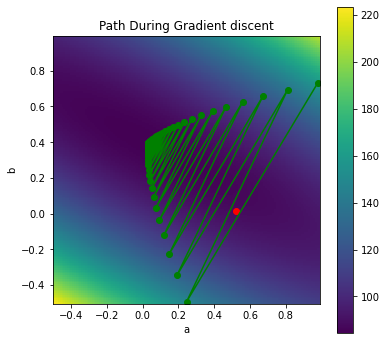

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))
X, Y, Z = create_mesh(least_squares_linear_on_x)
ax, CS = plot_contour(ax, X, Y, Z)
fig.colorbar(CS)

ax.plot([a], [b], 'ro')
ax.plot([x[0] for x in path], [x[1] for x in path], 'g-o')
plt.show()

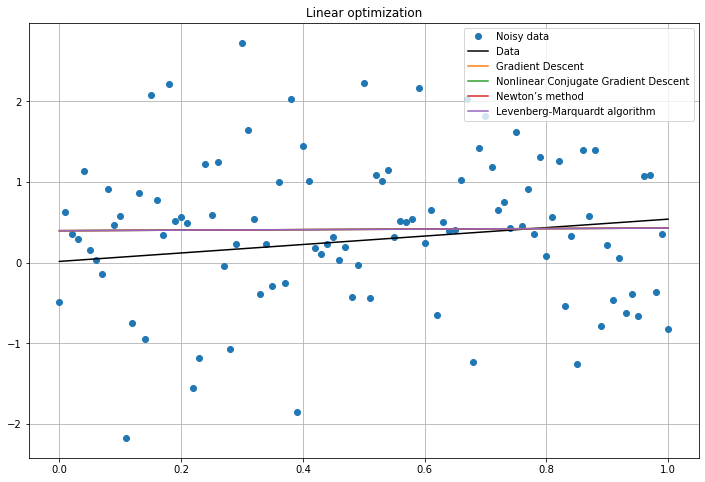

In [64]:
plt.figure(figsize=(12, 8))
plt.title('Linear optimization')
plt.grid()
plt.plot(x, noisy_y, 'o')
plt.plot(x, y, color='black')

plt.plot(x, a_gd * x + b_gd)
plt.plot(x, cd.x[0] * x + cd.x[1])
plt.plot(x, newton.x[0] * x + newton.x[1])
plt.plot(x, lm.x[0] * x + lm.x[1])
    
plt.legend(['Noisy data', 'Data', 'Gradient Descent', 'Nonlinear Conjugate Gradient Descent', 'Newton’s method', 'Levenberg-Marquardt algorithm'])
plt.show()

In [65]:
init_a, init_b = np.random.rand(), np.random.rand()
print('Rational optimization')

a_gd, b_gd, iter, f_call, path = gradient_descent('rational', init_a, init_b , x, noisy_y, 1e-3, .01)
print(f'Gradient Descent:\t ','Value a: {:.4f} Value b: {:.4f} Number of f-calculations: {:.0f} Number of iterations: {:.0f}'.format(a_gd, b_gd, f_call, iter))

cd = optimize.minimize(least_squares_rational_on_x, [init_a, init_b], method='CG', tol=0.001, options={'disp': True})
print(f'Conjugate Gradient Descent:\t ','Value a: {:.4f} Value b: {:.4f}'.format(cd.x[0], cd.x[1]))

newton = optimize.minimize(least_squares_rational_on_x, [init_a, init_b], method='BFGS', tol=0.001, options={'disp': True})
print(f'Newton’s method:\t ','Value a: {:.4f} Value b: {:.4f}'.format(newton.x[0], newton.x[1]))

lm = optimize.least_squares(rat_resid, [init_a, init_b], args=(x, noisy_y), method='lm', xtol=0.001)
print(f'Levenberg-Marquardt algorithm:\t ','Value a: {:.4f} Value b: {:.4f} Number of f-calculations: {:.0f}'.format(lm.x[0], lm.x[1], lm["nfev"]))

Rational optimization
Gradient Descent:	  Value a: 0.4078 Value b: -0.0265 Number of f-calculations: 72 Number of iterations: 72
Optimization terminated successfully.
         Current function value: 84.429318
         Iterations: 6
         Function evaluations: 48
         Gradient evaluations: 16
Conjugate Gradient Descent:	  Value a: 0.4040 Value b: -0.0435
Optimization terminated successfully.
         Current function value: 84.429318
         Iterations: 8
         Function evaluations: 33
         Gradient evaluations: 11
Newton’s method:	  Value a: 0.4040 Value b: -0.0435
Levenberg-Marquardt algorithm:	  Value a: 0.4040 Value b: -0.0437 Number of f-calculations: 28


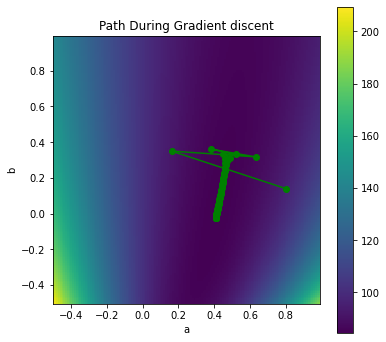

In [66]:
fig, ax = plt.subplots(figsize=(6, 6))
X, Y, Z = create_mesh(least_squares_rational_on_x)
ax, CS = plot_contour(ax, X, Y, Z)
fig.colorbar(CS)

ax.plot([x[0] for x in path], [x[1] for x in path], 'g-o')

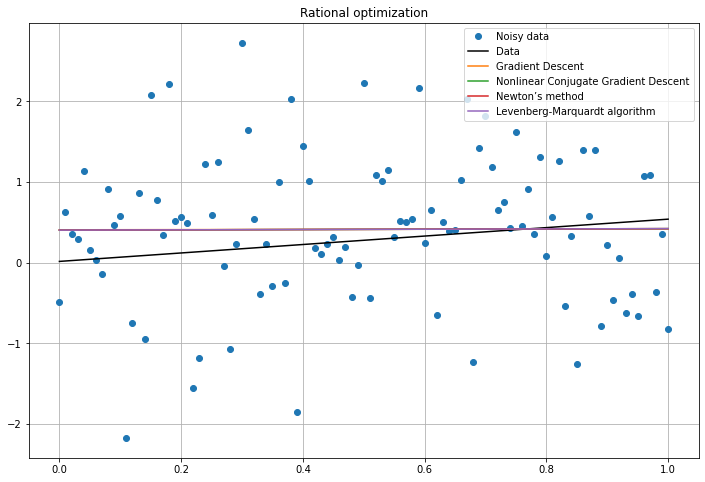

In [67]:
plt.figure(figsize=(12, 8))
plt.title('Rational optimization')
plt.grid()
plt.plot(x, noisy_y, 'o')
plt.plot(x, y, color='black')

plt.plot(x, a_gd / (1 + b_gd * x))
plt.plot(x, cd.x[0] / (1 + cd.x[1] * x))
plt.plot(x, newton.x[0]/ (1 + newton.x[1] * x))
plt.plot(x,  lm.x[0]/ (1 + lm.x[1] * x))
    
plt.legend(['Noisy data', 'Data', 'Gradient Descent', 'Nonlinear Conjugate Gradient Descent', 'Newton’s method', 'Levenberg-Marquardt algorithm'])
plt.show()